In [6]:
'''----------------------------------------------------------------------------
       ___       |
     _|o_ |_     |   Language: Python 3.x
    /  ___| \    |   Website: https://github.com/StasF1/dualFuelEngine
    \_| ____/    |   Copyright (C) 2018-2020 Stanislau Stasheuski
      |__o|      |
-------------------------------------------------------------------------------
License
    This file is part of dualFuelEngine – OpenFOAM addition.

    dualFuelEngine (like OpenFOAM) is free software: you can redistribute it 
    and/or modify it under the terms of the GNU General Public License as
    published by the Free Software Foundation, either version 3 of the License,
    or (at your option) any later version.

    dualFuelEngine (like OpenFOAM) is distributed in the hope that it will be
    useful, but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
    See the GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this repository. If not, see <http://www.gnu.org/licenses/>.

File
    Man_BnW.ipynb

Description
    MAN_BnW Diesel-RK & FlowVision postprocessing

----------------------------------------------------------------------------'''

import glob, os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy                import interpolate
from IPython.display      import Image
from IPython.core.display import display, HTML, Markdown, Javascript

sys.path.insert(1, '../DRK2Py');    from DRK2PyDict import *

%matplotlib inline

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

# Hide code cells
HTML(
    '''
    <script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    The raw code for this Juputer Notebook is by default hidden for easier reading.
    To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.
    '''
)

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#ВВЕДЕНИЕ" data-toc-modified-id="ВВЕДЕНИЕ-1"><strong>ВВЕДЕНИЕ</strong></a></span></li><li><span><a href="#1-Подготовка-данных---подготовка-геометрии,-постановка-задачи-и-подбор-начальных-и-граничных-условий" data-toc-modified-id="1-Подготовка-данных---подготовка-геометрии,-постановка-задачи-и-подбор-начальных-и-граничных-условий-2"><strong>1 Подготовка данных - подготовка геометрии, постановка задачи и подбор начальных и граничных условий</strong></a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#1.1-Верификация-протитотипа-c-использованием-термодинимической-модели" data-toc-modified-id="1.1-Верификация-протитотипа-c-использованием-термодинимической-модели-2.0.1"><strong>1.1 Верификация протитотипа c использованием термодинимической модели</strong></a></span></li><li><span><a href="#1.2-Определение-начальных-и-граничных-условий" data-toc-modified-id="1.2-Определение-начальных-и-граничных-условий-2.0.2"><strong>1.2 Определение начальных и граничных условий</strong></a></span></li></ul></li></ul></li><li><span><a href="#2-Расчёт-во-FlowVision" data-toc-modified-id="2-Расчёт-во-FlowVision-3"><strong>2 Расчёт во FlowVision</strong></a></span></li></ul></div>

In [7]:
''' Plot parameters '''

xFigSize         = 20
yFigSize         = 8

titleFontSize    = 16
subplotFontSize  = 14
labelFontSize    = 16
legendFontSize   = 12
ticksFontSize    = 12

linewidthHeavy   = 2
linewidthLight   = 1

# **ВВЕДЕНИЕ**
В настоящее время активно развиваются двигатели внутреннего сгорания работающие на газовом топливе, в частности, в крупных судовых  малооборотных двигателях (МОД) изучается и развивается применение в одном рабочем процессе двух видов топлива – газового и дизельного. Так как в таких двигателях воспламенение происходит от сжатия, а газовое топливо от сжатия не воспламеняется (подобно дизельному топливу) при увеличении давления. Для воспламенения газа используют зажигание от электрической искры или от запальной дозы дизельного топлива (pilot injection). Горение запальной дозы уже вызывает воспламенение основной дозы топлива — газа. Впрыск газа происходит во время такта сжатия (газовые форсунки располагаются в середине цилиндра) (см. рисунок 1).

<br/>
<center>
  <img
    src="https://github.com/StasF1/dualFuelEngine/wiki/src/images/master's/[1]-1.png"
    alt="Figure 1"
    width="400" /* height="200" */
  />
  <b> Рисунок 1 </b> - Подача газа (слева) и сгорание (справа) в МОД <span class="mark">[17, с.3]</span>
</center>
<br/>

Таким образом, внутри цилиндра во время такта сжатия располагается: свежий заряд, продукты сгорания и газ являющийся основой дозой топливa. Для изучения рабочего процесса необходимо знать поля скоростей и концентраций этих газов в цилиндре, которые были получены с помощью методов CFD-моделирования в программном комплексе FlowVision.

# **1 Подготовка данных - подготовка геометрии, постановка задачи и подбор начальных и граничных условий**
В качестве объекта исследования был выбран малооборотный крупный дизель 6ДНК70/280, прототипом которого является **MAN 6S70ME-C8.2-GI-TII**.

### **1.1 Верификация протитотипа c использованием термодинимической модели**
Для провоедения CFD-расчёта необходимо задавать начальные и граничные условия, для определения которых можно использовать  проведена термодинимическую модель рабочего процесса двигателя внутренного сгорания. Такая модель лежит в основе ПК Дизель-РК <span class="mark">[ДРК]</span>. С использованием данного пакета была идентификация прототипа и оптимизирован рабочий процесс, в частности выбраны оптимальные:
- степень сжатия, $\epsilon$;
- фазы газораспределения (из условия наибольшего коэффициента наполнения $\eta_{v}$);
- угол опережения впрыска, $\theta$;
- давление наддува (степень повышения давления компрессора, $\pi_{к}$);
- для номинального режима (19620 кВт при 91 об/мин) с целью получения удельного эффективного расхода топлива $g_{e}$ не более 0,2  кг/кВт⋅ч, при удовлетворении следующим ограничениям и условиям:
- обеспечения требуемой мощности $N_{e}$ 19620 кВт при номинальной частоте вращения $n$ = 91 об/мин
- максимальное давление цикла $p_{z}$ не более 210 бар;
- максимальная жесткость  цикла ${dp \over dφ}$ не более 7 бар/градус ПКВ;
- средняя температура перед турбиной $T^{*}_{t}$ не более 800 К;
(результаты расчёта см. в Приложении А).

Таким образом, проводим идентификацию математической модели ПК Дизель-РК для обеспечения совпадения результатов моделирования с номинальной мощностью прототипа  6ДНК70/280 (MAN 6S70ME-C8.2-GI-TII) с учётом заданных ограничений.
Проводим одномерное сканирование по степени сжатия $\epsilon$ и степени повышения давления в компрессоре $\pi_{к}$. Выбираем значение $\epsilon$ = 15,5 и $\pi_{к}$ = 3,7.

<br/>
<center>
  <img
    src="https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/DRK-1.png"
    alt="Figure 1.1"
    width="600"
  />
  <b> Рисунок 1.1 </b> – Результат двумерного сканирования по степени сжатия по степени сжатия $\epsilon$ (ось абсцисс) и степени повышения давления в компрессоре  $\pi_{к}$ (ось ординат)
</center>
<br/>

Для обеспечения наибольшего коэффициента наполнения Vпроводим оптимизацию углам открытия клапана/впускных органов (см. рисунок 2.2). Стоит упомянуть, что так как двигатель двухтактный, то IVO = IVC. Также определяем оптимальный угол открытия выпускного клапана (см. рисунок 2.3) c учётом ограничений.

В итоге, принимаем:
- IVO = IVC = 46°
- EVC = 46°
- EVO = 71°

<br/>
<center>
  <img
    src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/DRK-2.png"
    alt = "Figure 1.2"
    width = "600"
  />
  <b> Рисунок 1.2 </b> – Исследование влияния углов начала впуска (IPO) и конца выпуска (EVC) на параметры оптимизации двигателя
</center>

<br/>
<center>
  <img
    src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/DRK-3.png"
    alt = "Figure 1.2"
    height = "200"
  />
  <b> Рисунок 1.3 </b> – Исследование угла открытия выпускного клапана (EVO)
</center>
<br/>

Проводим окончательную оценку по степени повышения давления в компрессоре $\pi_{к}$ и углу опережения впрыска $\theta$ (см. рисунок 1.4).

<br/>
<center>
  <img
    src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/DRK-4.png"
    alt = "Figure 1.2"
    height = "200"
  />
  <b> Рисунок 1.4 </b> – Зависимость $N_{e}$, $g_{e}$, $p_{z}$, ${dp \over dφ}$ от $\theta$ и $\pi_{к}$
</center>
<br/>

После проведённой оптимизации были проведёно термодинамическое моделирование двигателя (см. Приложение А) и определены интегральные параметры двигателя (значения осреднённых параметров таких как давление и температура внутри цилиндра от угла поворота коленчатого вала), на основе которого можно получить начальные и граничные условия. На этапе идентификации были 

### **1.2 Определение начальных и граничных условий**
CFD-моделировние было решено проводить с момента открытия выпускного клапана (EVO), который был определён при идентификации прототипа – начальные условия (для давления и температуры) внутри цилиндра принимаем именно для этого момента времени. Момент открытия выпускного клапана обозначен синей точкой (см. рисунок 1.5).

In [8]:
''' Get Diesel-RK data'''

# Cylinder parameters
# ~~~~~~~~~~~~~~~~~~~
#- Cylinder w/ combustion parameters
indWComMatrix = np.loadtxt(
    glob.glob('../DRK2Py/tmp2020-02*/*.ind')[0], skiprows = 19, encoding = 'cp1252'
)
phi           = indWComMatrix[:,0]       # CA
p             = indWComMatrix[:,1]*1e+05 # Pa, cylinder pressure
T             = indWComMatrix[:,2]       # K, average cylinder temperature
V             = indWComMatrix[:,3]       # m^3, cylinder volume
alpha_w       = indWComMatrix[:,4]*1e+05 # Pa, heat transfer factor in cylinder (Woschni)
p_1ring       = indWComMatrix[:,5]       # W/m^2/K, pressure after first piston ring
G_bb          = indWComMatrix[:,6]       # kg/s, mass gas flow blowed-by through 1 piston ring
pistonFromBDC = indWComMatrix[:,7]*1e-03 # m, piston position from BDC
x             = indWComMatrix[:,8]       # heat release fraction

# Compression cycle from EVO parameters
p_DrkWCom = np.roll(p, EVO)[0:180 + EVO]
T_DrkWCom = np.roll(T, EVO)[0:180 + EVO]

#- Cylinder w/o combustion parameters
indWoComMatrix = np.loadtxt(
    glob.glob('../DRK2Py/tmp2020-03*/*.ind')[0], skiprows = 19, encoding = 'cp1252'
)
pWoCom = indWoComMatrix[:,1]*1e+05 # Pa, cylinder pressure
TWoCom = indWoComMatrix[:,2]       # K, average cylinder temperature

# Compression cycle from EVO parameters
p_DrkWoCom = np.roll(pWoCom, EVO)[0:180 + EVO]
T_DrkWoCom = np.roll(TWoCom, EVO)[0:180 + EVO]


# Gas exchange parameters
# ~~~~~~~~~~~~~~~~~~~~~~~
gasMatrix = np.loadtxt(
    glob.glob('../DRK2Py/tmp2020-02*/*.gas')[0], skiprows = 31, encoding = 'cp1252'
)
p_exhPipe     = gasMatrix[:,5] *1e+05 # Pa, exhaust pipe pressure
T_exhPipe     = gasMatrix[:,6]        # T, exhaust pipe temperature
p_IP          = gasMatrix[:,12]*1e+05 # Pa, inlet port pressure
T_IP          = gasMatrix[:,13]       # T, inlet port temperature
G_inlet       = gasMatrix[:,14]       # kg/s, inlet mass flow rate
Lv_exh        = gasMatrix[:,19]*1e-03 # m, valve position BDC

In [9]:
''' Calculate data '''

degDeltaT = 60/n/360

#- Create arrays of the moving parts
pistonCoord = np.roll(pistonFromBDC, EVO)[0:180 + EVO]
pistonCoord = pistonCoord - pistonCoord[0]
pistonU     = np.gradient(pistonCoord, np.arange(0, (EVO + 180)*degDeltaT, degDeltaT)) # dt/dt

valveCoordFrequency = 3

valveCoordObj = interpolate.CubicSpline(
    np.arange(0, (EVO + 180)*degDeltaT, degDeltaT), # t
  - np.pad(Lv_exh, (0, len(pistonCoord) - len(Lv_exh)), 'constant') # valveCoord
)
valveCoord = valveCoordObj(np.arange(0, (EVO + 180)*degDeltaT, degDeltaT*valveCoordFrequency))

valveU = np.gradient(valveCoord, np.arange(0, (EVO + 180)*degDeltaT, degDeltaT*valveCoordFrequency)) # dt/dt

#- Create inlet/injection arrays
G_injection = np.concatenate((
    np.zeros(EVO + EVC - 1),
    np.arange(0, injG_max + injG_max/injCA2Max, injG_max/injCA2Max),
    np.full(180 - (EVC + injCA2Max), injG_max)
))
rhoU_injection = G_injection/injArea

G_inlet = np.pad(
    G_inlet, (0, len(G_injection) - len(G_inlet)), 'constant'
)

rhoU_inlet = G_inlet/inletArea

Text(255, 1365.9439999999997, 'IC (EVO)')

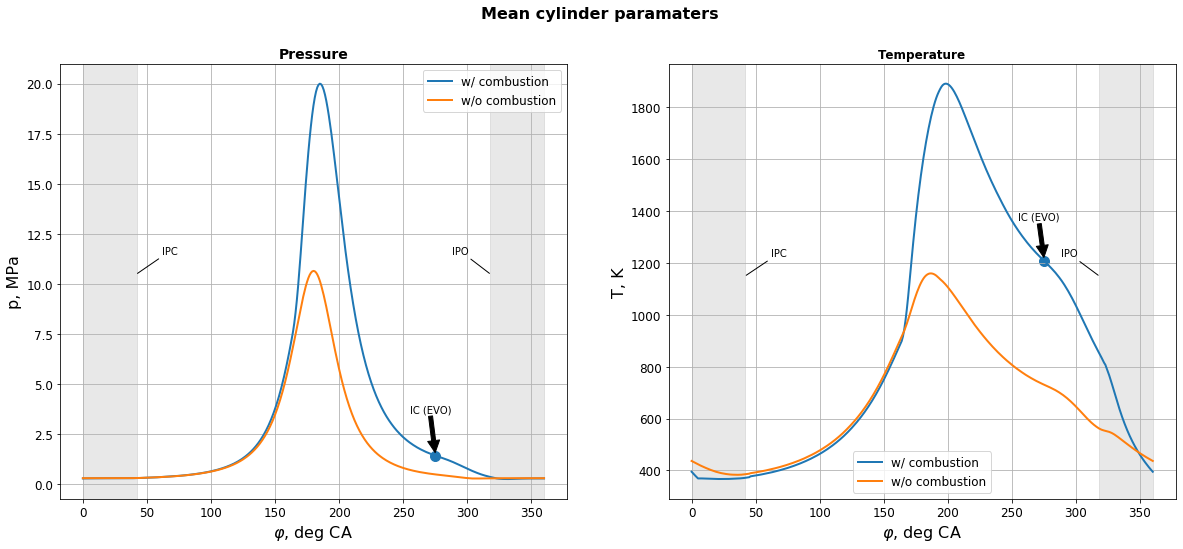

In [10]:
''' Mean cylinder parameters (all cycles) '''

#- Pressure
plt.figure(
    figsize = (xFigSize, yFigSize)#, dpi = 80, facecolor = 'w', edgecolor = 'k'
).suptitle(
    'Mean cylinder paramaters', fontweight = 'bold', fontsize = titleFontSize
)
plt.subplot(121).set_title(
    f'Pressure', fontweight = 'bold', fontsize = subplotFontSize
)
plt.plot(
    p*1e-06,
    linewidth = linewidthHeavy,
    label = 'w/ combustion'
)
plt.plot(
    pWoCom*1e-06,
    linewidth = linewidthHeavy,
    label = 'w/o combustion'
)
plt.xticks( fontsize = ticksFontSize );    plt.yticks( fontsize = ticksFontSize )
plt.scatter(360 - EVO, p[360 - EVO]*1e-06, s = 100, marker = 'o')
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA', fontsize = labelFontSize )
plt.ylabel( 'p, MPa', fontsize = labelFontSize )

plt.axvspan(0,         IPO, alpha = 0.18, color = 'grey')
plt.axvspan(360 - IPO, 360, alpha = 0.18, color = 'grey')
plt.annotate(
    'IPC', xy = (IPO, 10.5), xycoords = 'data',
    xytext = (IPO + 20, 11.5),
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)
plt.annotate(
    'IPO', xy = (360 - IPC, 10.5), xycoords = 'data',
    xytext = ((360 - IPC) - 30, 11.5),
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)
plt.annotate(
    'IC (EVO)', xy = (360 - EVO, p[360 - EVO]*1.1e-06),
    xytext = (360 - EVO - 20, p[360 - EVO]*2.5e-06),
    arrowprops = dict(facecolor = 'black', shrinkB=1)
)


#- Temperature
plt.subplot(122).set_title(
    f'Temperature', fontweight = 'bold', fontsize = 12
)
plt.plot(
    T,
    linewidth = linewidthHeavy,
    label = 'w/ combustion'
)
plt.plot(
    TWoCom,
    linewidth = linewidthHeavy,
    label = 'w/o combustion'
)
plt.xticks(fontsize = ticksFontSize);    plt.yticks(fontsize = ticksFontSize)
plt.scatter(360 - EVO, T[360 - EVO], s = 100, marker = 'o')
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA', fontsize = labelFontSize )
plt.ylabel( 'T, K', fontsize = labelFontSize )

plt.axvspan(0,         IPO, alpha = 0.18, color = 'grey')
plt.axvspan(360 - IPO, 360, alpha = 0.18, color = 'grey')
plt.annotate(
    'IPC', xy = (IPO, 1150), xycoords = 'data',
    xytext = (IPO + 20, 1225),
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)
plt.annotate(
    'IPO', xy = (360 - IPC, 1150), xycoords = 'data',
    xytext = ((360 - IPC) - 30, 1225),
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)
plt.annotate(
    'IC (EVO)', xy = (360 - EVO, T[360 - EVO]*1.01),
    xytext = (360 - EVO - 20, T[360 - EVO]*1.13),
    arrowprops = dict(facecolor = 'black', shrinkB=1)
)

<center>
  <b> Рисунок 1.5 </b> – Интегральные параметры внутри цилиндра (синей точкой обозначен момент открытия выпускного клапана - EVO)
</center>
<br/>

Таким образом начальные условия в цилиндре:
- $p_{cyl0}$ = {{round(p[360 - EVO]*1e-06, 4)}} (МПа), абсолютное давление
- $T_{cyl0}$ = {{T[360 - EVO]}} (K)

Для определения граничных условий на впуске и выпуске используем параметры во впускном и выпускном коллекторах соответственно, которые также были получены при идентификации двигателя (см. рисунок 1.6).

Text(0, 0.5, 'T, K')

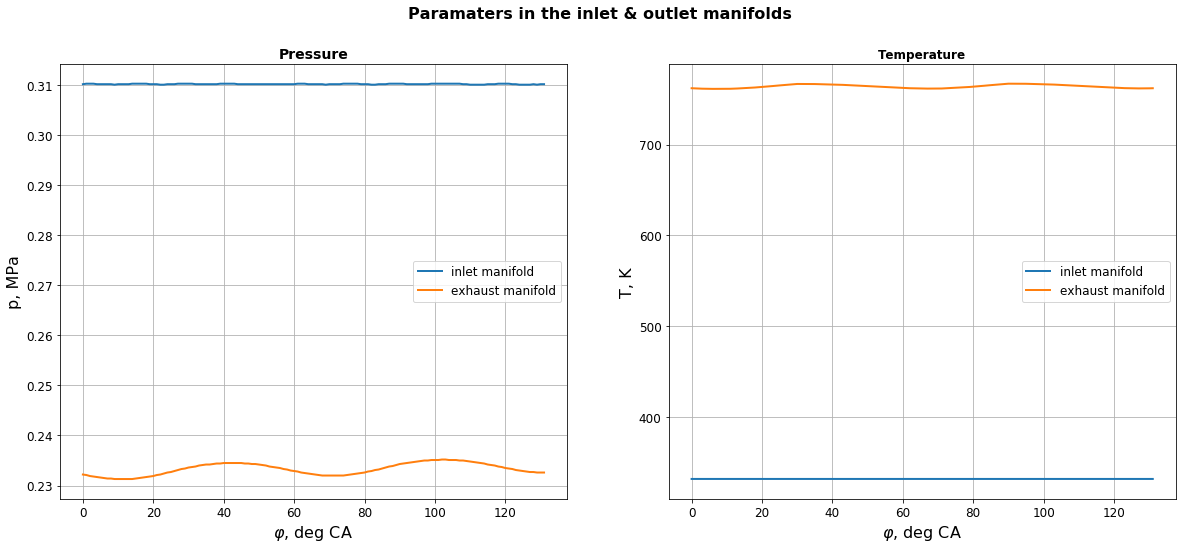

In [11]:
plt.figure(
    figsize = (xFigSize, yFigSize)#, dpi = 80, facecolor = 'w', edgecolor = 'k'
).suptitle(
    'Paramaters in the inlet & outlet manifolds', fontweight='bold', fontsize = titleFontSize
)
plt.subplot(121).set_title(
    'Pressure', fontweight = 'bold', fontsize = subplotFontSize
)
plt.plot(
    p_IP*1e-06,
    linewidth = linewidthHeavy,
    label = 'inlet manifold'
)
plt.plot(
    p_exhPipe*1e-06,
    linewidth = linewidthHeavy,
    label = 'exhaust manifold'
)
plt.xticks(fontsize = ticksFontSize);    plt.yticks(fontsize = ticksFontSize)
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA', fontsize = labelFontSize )
plt.ylabel( 'p, MPa', fontsize = labelFontSize )

plt.subplot(122).set_title(
    'Temperature', fontweight = 'bold', fontsize = 12
)
plt.plot(
    T_IP,
    linewidth = linewidthHeavy,
    label = 'inlet manifold'
)
plt.plot(
    T_exhPipe,
    linewidth = linewidthHeavy,
    label = 'exhaust manifold'
)
plt.xticks(fontsize = ticksFontSize);    plt.yticks(fontsize = ticksFontSize)
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA', fontsize = labelFontSize )
plt.ylabel( 'T, K', fontsize = labelFontSize )

<center>
  <b> Рисунок 1.6 </b> – Интегральные параметры во впускном и выпускном коллекторах соответственно
</center>
<br/>

Так как во время рабочего процесса колебания давления и температуры в коллекторах незначительны, то для определения граничных условий принимаем срадние значения этих параметров:
- Граничные условия на впуске:
    + ($p_{inlet}$ = {{round(np.mean(p_IP)*1e-06, 4)}} (МПа), абсолютное давление)$^{1}$
    + $T_{inlet}$ = {{round(np.mean(T_IP), 1)}} (K)
- Граничные условия на выпуске:
    + $p_{outlet}$ = {{round(np.mean(p_exhPipe)*1e-06, 4)}} (МПа), абсолютное давление
    + $T_{outlet}$ = {{round(np.mean(T_exhPipe), 1)}} (K)
---
$^{1}$ - давление на впуске при расчёте не использовалось и представлено как справочное значение

# **2 Расчёт во FlowVision**


In [12]:
''' Get FlowVision data '''

#- Cylinder pressure
pCylGloMatrix = pd.read_csv(
    glob.glob('MAN_BnW-quarter/cylP.glo')[0],
    encoding = 'utf-8',
    delimiter = '\t'
)

#- Cylinder temperature
TCylGloMatrix = pd.read_csv(
    glob.glob('MAN_BnW-quarter/cylT.glo')[0],
    encoding = 'utf-8',
    delimiter = '\t'
)

Text(0.40457063711911356, 0.65, 'IPC')

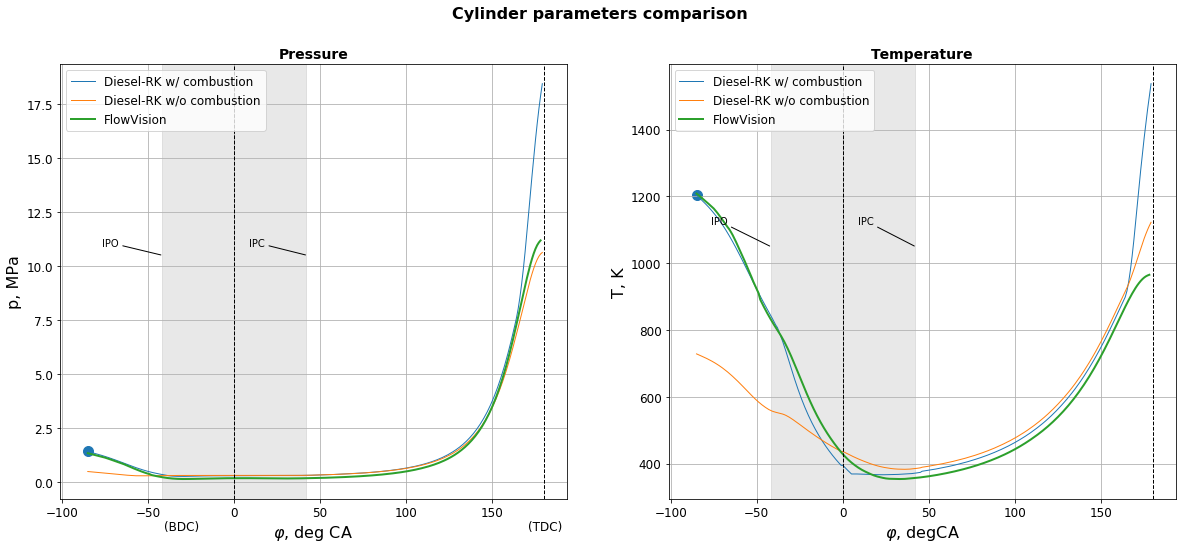

In [13]:
''' Integal paramaters in the cylinder '''

#- Pressure
plt.figure(
    figsize = (xFigSize, yFigSize)#, dpi = 80, facecolor = 'w', edgecolor = 'k'
).suptitle(
    'Cylinder parameters comparison', fontweight='bold', fontsize = titleFontSize
)
plt.subplot(121).set_title(
    f'Pressure', fontweight = 'bold', fontsize = subplotFontSize
)
plt.plot(
    range(-EVO, 180),
    p_DrkWCom*1e-06,
    linewidth = linewidthLight,
    label = 'Diesel-RK w/ combustion'
)
plt.scatter(-EVO, p_DrkWCom[0]*1e-06, s = 100, marker='o')
plt.plot(
    range(-EVO, 180),
    p_DrkWoCom*1e-06,
    linewidth = linewidthLight,
    label = 'Diesel-RK w/o combustion'
)
plt.plot(
    range(-EVO, len(pCylGloMatrix['AverageByMass']) - EVO),
    pCylGloMatrix['AverageByMass']*1e-06,
    linewidth = linewidthHeavy,
    label = 'FlowVision'
)
plt.xticks( fontsize = ticksFontSize );    plt.yticks( fontsize = ticksFontSize )
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA',fontsize = labelFontSize )
plt.ylabel( 'p, MPa', fontsize = labelFontSize )

plt.annotate(
    '(BDC)', (1, 1),
    xytext = (EVO/len(phi)*1.17, -0.05), textcoords = 'axes fraction',
    horizontalalignment = 'right', verticalalignment = 'top',
    fontsize = legendFontSize
)
plt.axvline(
    x = 0,
    linewidth = 1,
    color = 'black',
    linestyle = '--'
)
plt.annotate(
    '(TDC)', (1, 1),
    xytext = (0.99, -0.05), textcoords = 'axes fraction',
    horizontalalignment = 'right', verticalalignment = 'top',
    fontsize = legendFontSize
)
plt.axvline(
    x = 180,
    linewidth = 1,
    color = 'black',
    linestyle = '--'
)
plt.axvspan(-IPO, IPC, alpha=0.18, color='grey')
plt.annotate(
    'IPO', xy = (-IPO, 10.5),  xycoords = 'data',
    xytext = (IPO/len(phi), 0.6), textcoords = 'axes fraction',
    horizontalalignment = 'right', verticalalignment = 'top',
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)
plt.annotate(
    'IPC', xy = (IPC, 10.5),  xycoords = 'data',
    xytext = ((IPC + EVO)/len(phi)*1.15, 0.6), textcoords = 'axes fraction',
    horizontalalignment = 'right', verticalalignment = 'top',
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)


#- Temperature
plt.subplot(122).set_title(
    f'Temperature', fontweight = 'bold', fontsize = subplotFontSize
)
plt.plot(
    range(-EVO, 180),
    T_DrkWCom,
    linewidth = linewidthLight,
    label = 'Diesel-RK w/ combustion'
)
plt.scatter(-EVO, T_DrkWCom[0], s = 100, marker = 'o')
plt.plot(
    range(-EVO, 180),
    T_DrkWoCom,
    linewidth = linewidthLight,
    label = 'Diesel-RK w/o combustion'
)
plt.plot(
    range(-EVO, len(TCylGloMatrix['AverageByMass']) - EVO),
    TCylGloMatrix['AverageByMass'] + 273,
    linewidth = linewidthHeavy,
    label = 'FlowVision'
)
plt.xticks( fontsize = ticksFontSize );    plt.yticks( fontsize = ticksFontSize )
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, degCA', fontsize = labelFontSize )
plt.ylabel( 'T, K', fontsize = labelFontSize )

plt.axvline(
    x = 0,
    linewidth = 1,
    color = 'black',
    linestyle = '--'
)
plt.axvline(
    x = 180,
    linewidth = 1,
    color = 'black',
    linestyle = '--'
)
plt.axvspan(-IPO, IPC, alpha=0.18, color='grey')
plt.annotate(
    'IPO', xy = (-IPO, 1050), xycoords = 'data',
    xytext = (IPO/len(phi), 0.65), textcoords = 'axes fraction',
    horizontalalignment = 'right', verticalalignment = 'top',
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)
plt.annotate(
    'IPC', xy = (IPC, 1050), xycoords = 'data',
    xytext = ((IPC + EVO)/len(phi)*1.15, 0.65), textcoords = 'axes fraction',
    horizontalalignment = 'right', verticalalignment = 'top',
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)